In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import lstm
import data_prep
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:
#get max value of Radiation
max_radiation = df['Radiation'].max()
print(max_radiation)
#get min value of Radiation
min_radiation = df['Radiation'].min()
print(min_radiation)


1601.26
1.11


In [4]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


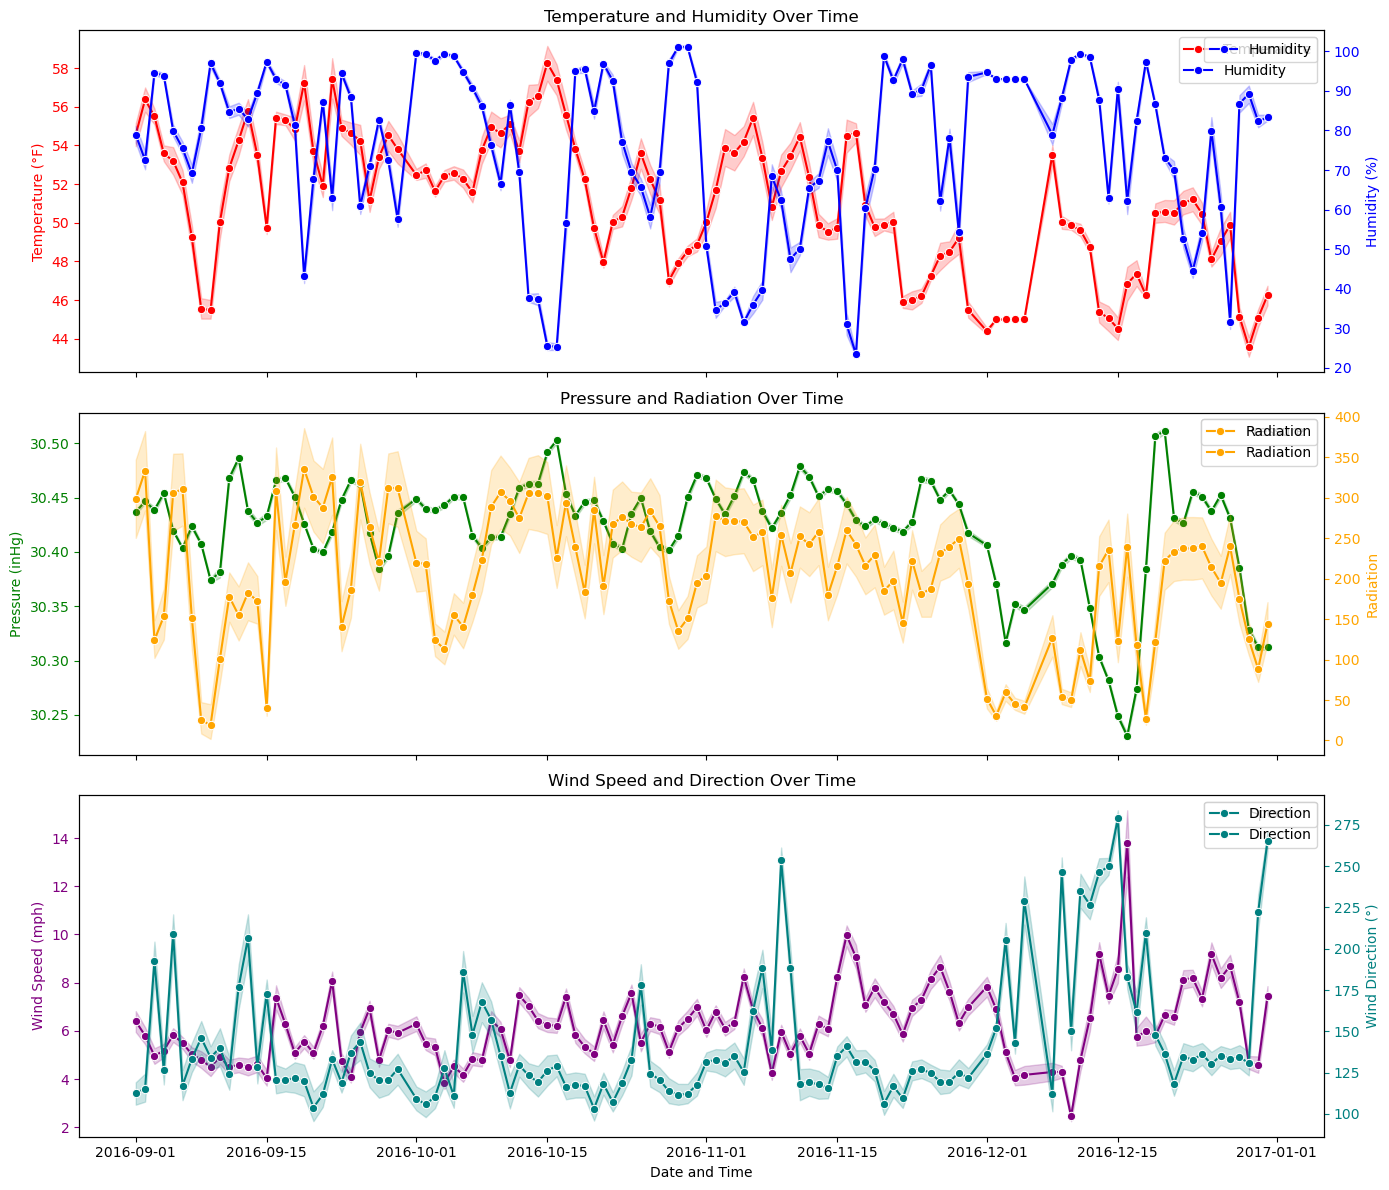

In [5]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




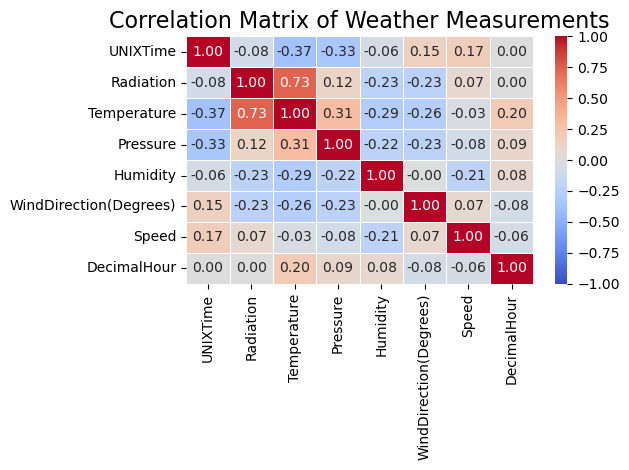

In [6]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## LSTM NN

In [7]:


target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, combined_transform_info, timestamps_train, timestamps_val, timestamps_test = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        #min_target_threshold=1.2
)


Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [11]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
#device = torch.device("mps")
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=5,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-04-28 18:20:31,798] A new study created in memory with name: no-name-d5bc5491-6780-4d95-bdd8-ed145efbba2a


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.1, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X

[I 2025-04-28 18:21:30,101] Trial 1 finished with value: 0.9553347707124896 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.00024739967830706317, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 1 with value: 0.9553347707124896.


Trial 1: hidden_dim=64, num_layers=1, dropout_prob=0.2, learning_rate=0.000247, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9553
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.1, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 3/5 - Train loss: 0.269060 - Val loss: 0.227155 - Val RMSE: 0.085475 - Val R²: 0.945428 - Val MAPE: 44.03%
Epoch 4/5 - Train loss: 0.007362 - Val loss: 0.005286 - Val RMSE: 0.072703 - Val R²: 0.960518 - Val MAPE: 74.61%
Epoch 4/5 - Train loss: 0.044924 - Val loss: 0.038308 - Val RMSE: 0.076828 - Val R²: 0.955912 - Val MAPE: 32.52%
Epoch 3/5 - Train loss: 0.046143 - Val loss: 0.041208 - Val RMSE: 0.108014 - Val R²: 0.912853 - Val MAPE: 32.33%
Epoch 1/5 - Train loss: 0.208517 - Val loss: 0.145408 - 

[I 2025-04-28 18:21:59,922] Trial 5 finished with value: 0.9614524017194156 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.0002912639801654218, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.5}. Best is trial 5 with value: 0.9614524017194156.


Epoch 1/5 - Train loss: 0.058661 - Val loss: 0.007700 - Val RMSE: 0.087751 - Val R²: 0.942484 - Val MAPE: 175.60%
Trial 5: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000291, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9615
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.5, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.040555 - Val loss: 0.007750 - Val RMSE: 0.088032 - Val R²: 0.942114 - Val MAPE: 86.65%
Epoch 5/5 - Train loss: 0.043561 - Val loss: 0.030978 - Val RMSE: 0.072918 - Val R²: 0.960285 - Val MAPE: 25.76%
Training complete. Best model saved.


[I 2025-04-28 18:22:01,342] Trial 8 finished with value: 0.9602847322606005 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0003567074548012013, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 5 with value: 0.9614524017194156.


Trial 8: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000357, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9603
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
Epoch 4/5 - Train loss: 0.201679 - Val loss: 0.163836 - Val RMSE: 0.086437 - Val R²: 0.944193 - Val MAPE: 31.33%
Epoch 4/5 - Train loss: 0.036102 - Val loss: 0.027795 - Val RMSE: 0.090519 - Val R²: 0.938798 - Val MAPE: 21.57%
Epoch 1/5 - Train loss: 0.082043 - Val loss: 0.009654 - Val RMSE: 0.098256 - Val R²: 0.927889 - Val MAPE: 242.33%
Epoch 2/5 - Train loss: 0.080896 - Val loss: 0.073870 - Val RMSE: 0.088071 - Val R²: 0.942063 - Val MAPE: 66.35%
Epoch 5/5 - Train loss: 0.163130 - Val loss: 0.116199 - Val RMSE: 0.086805 - Val R²: 0.943716 - Val MAPE: 21.78%
Traini

[I 2025-04-28 18:22:31,981] Trial 4 finished with value: 0.9437161833238369 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00020325608394808676, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 5 with value: 0.9614524017194156.


Trial 4: hidden_dim=64, num_layers=3, dropout_prob=0.1, learning_rate=0.000203, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9437
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 3/5 - Train loss: 0.008006 - Val loss: 0.006704 - Val RMSE: 0.081876 - Val R²: 0.949927 - Val MAPE: 82.28%
Epoch 3/5 - Train loss: 0.061332 - Val loss: 0.031113 - Val RMSE: 0.083221 - Val R²: 0.948268 - Val MAPE: 26.06%
Epoch 3/5 - Train loss: 0.125602 - Val loss: 0.073140 - Val RMSE: 0.080430 - Val R²: 0.951680 - Val MAPE: 23.23%
Epoch 1/5 - Train loss: 0.631350 - Val loss: 0.285899 - Val RMSE: 0.130573 - Val R²: 0.872650 - Val MAPE: 55.38%
Epoch 2/5 - Train loss: 0.023016 - Val loss: 0.007250 - 

[I 2025-04-28 18:22:52,523] Trial 11 finished with value: 0.9545967704749175 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0003362097353305904, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 5 with value: 0.9614524017194156.


Trial 11: hidden_dim=64, num_layers=3, dropout_prob=0.1, learning_rate=0.000336, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9546
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.5, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.773600 - Val loss: 0.468273 - Val RMSE: 0.467504 - Val R²: -0.632526 - Val MAPE: 80.20%
Epoch 1/5 - Train loss: 0.508941 - Val loss: 0.101140 - Val RMSE: 0.102831 - Val R²: 0.921017 - Val MAPE: 31.87%
Epoch 3/5 - Train loss: 0.018987 - Val loss: 0.006588 - Val RMSE: 0.081169 - Val R²: 0.950789 - Val MAPE: 144.63%
Epoch 4/5 - Train loss: 0.038109 - Val loss: 0.031550 - Val RMSE: 0.075762 - Val R²: 0.957126 - Val MAPE: 25.94%
Epoch 1/5 - Train loss: 0.261919 - Val loss: 0.118987 

[I 2025-04-28 18:23:49,498] Trial 12 finished with value: 0.9534035271117292 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0004599649893387201, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 5 with value: 0.9614524017194156.


Trial 12: hidden_dim=64, num_layers=3, dropout_prob=0.1, learning_rate=0.000460, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9534
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 3/5 - Train loss: 0.219197 - Val loss: 0.123140 - Val RMSE: 0.096949 - Val R²: 0.929794 - Val MAPE: 37.95%
Epoch 4/5 - Train loss: 0.097404 - Val loss: 0.072512 - Val RMSE: 0.071346 - Val R²: 0.961979 - Val MAPE: 23.28%
Epoch 5/5 - Train loss: 0.006802 - Val loss: 0.005201 - Val RMSE: 0.072116 - Val R²: 0.961154 - Val MAPE: 89.12%
Training complete. Best model saved.


[I 2025-04-28 18:24:09,050] Trial 6 finished with value: 0.9611539177378975 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.00011346384610770067, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 5 with value: 0.9614524017194156.


Trial 6: hidden_dim=128, num_layers=1, dropout_prob=0.2, learning_rate=0.000113, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9612
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=5
Epoch 5/5 - Train loss: 0.039095 - Val loss: 0.025582 - Val RMSE: 0.083032 - Val R²: 0.948503 - Val MAPE: 20.54%
Training complete. Best model saved.
Epoch 5/5 - Train loss: 0.102301 - Val loss: 0.075807 - Val RMSE: 0.073222 - Val R²: 0.959952 - Val MAPE: 24.32%
Training complete. Best model saved.


[I 2025-04-28 18:24:11,020] Trial 9 finished with value: 0.9485032089577945 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.0001391442456802564, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 5 with value: 0.9614524017194156.
[I 2025-04-28 18:24:11,162] Trial 10 finished with value: 0.9599523118542772 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00018437314685124378, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 5 with value: 0.9614524017194156.


Trial 9: hidden_dim=128, num_layers=1, dropout_prob=0.2, learning_rate=0.000139, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9485
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.5, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
Trial 10: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000184, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9600
Epoch 5/5 - Train loss: 0.016877 - Val loss: 0.006949 - Val RMSE: 0.083363 - Val R²: 0.948092 - Val MAPE: 149.26%
Training complete. Best model saved.


[I 2025-04-28 18:24:13,893] Trial 14 finished with value: 0.9480917173101768 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00013261811905268436, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 5 with value: 0.9614524017194156.


Trial 14: hidden_dim=64, num_layers=3, dropout_prob=0.2, learning_rate=0.000133, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9481
Epoch 1/5 - Train loss: 0.706523 - Val loss: 0.168282 - Val RMSE: 0.119443 - Val R²: 0.893437 - Val MAPE: 31.38%
Epoch 4/5 - Train loss: 0.168927 - Val loss: 0.119431 - Val RMSE: 0.088324 - Val R²: 0.941730 - Val MAPE: 37.27%
Epoch 5/5 - Train loss: 0.095464 - Val loss: 0.078856 - Val RMSE: 0.070407 - Val R²: 0.962972 - Val MAPE: 25.42%
Training complete. Best model saved.


[I 2025-04-28 18:24:24,057] Trial 16 finished with value: 0.9629724744112734 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0004577631351350124, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9629724744112734.


Trial 16: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000458, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9630
Epoch 2/5 - Train loss: 0.194997 - Val loss: 0.161029 - Val RMSE: 0.094240 - Val R²: 0.933663 - Val MAPE: 30.82%
Epoch 3/5 - Train loss: 0.012714 - Val loss: 0.006657 - Val RMSE: 0.081589 - Val R²: 0.950278 - Val MAPE: 105.57%
Epoch 5/5 - Train loss: 0.135668 - Val loss: 0.115120 - Val RMSE: 0.086919 - Val R²: 0.943569 - Val MAPE: 35.91%
Training complete. Best model saved.
Epoch 3/5 - Train loss: 0.007086 - Val loss: 0.005996 - Val RMSE: 0.077437 - Val R²: 0.955210 - Val MAPE: 91.68%


[I 2025-04-28 18:24:44,146] Trial 15 finished with value: 0.9435690954917889 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00011269745416003912, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 16 with value: 0.9629724744112734.


Trial 15: hidden_dim=64, num_layers=3, dropout_prob=0.2, learning_rate=0.000113, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9436
Epoch 2/5 - Train loss: 0.181500 - Val loss: 0.139542 - Val RMSE: 0.102259 - Val R²: 0.921893 - Val MAPE: 26.80%
Epoch 2/5 - Train loss: 0.090953 - Val loss: 0.079281 - Val RMSE: 0.083987 - Val R²: 0.947312 - Val MAPE: 25.20%
Epoch 3/5 - Train loss: 0.181082 - Val loss: 0.134118 - Val RMSE: 0.073804 - Val R²: 0.959313 - Val MAPE: 25.99%
Epoch 4/5 - Train loss: 0.173545 - Val loss: 0.156067 - Val RMSE: 0.076173 - Val R²: 0.956660 - Val MAPE: 30.33%
Epoch 1/5 - Train loss: 0.515895 - Val loss: 0.128612 - Val RMSE: 0.119843 - Val R²: 0.892721 - Val MAPE: 38.25%
Epoch 5/5 - Train loss: 0.171210 - Val loss: 0.119141 - Val RMSE: 0.069906 - Val R²: 0.963498 - Val MAPE: 23.08%
Training complete. Best model saved.


[I 2025-04-28 18:25:17,690] Trial 19 finished with value: 0.9634981934677916 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.0006763005896189462, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.5}. Best is trial 19 with value: 0.9634981934677916.


Trial 19: hidden_dim=64, num_layers=2, dropout_prob=0.3, learning_rate=0.000676, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9635
Epoch 1/5 - Train loss: 0.278759 - Val loss: 0.100604 - Val RMSE: 0.156249 - Val R²: 0.817643 - Val MAPE: 27.53%
Epoch 4/5 - Train loss: 0.011805 - Val loss: 0.005996 - Val RMSE: 0.077436 - Val R²: 0.955211 - Val MAPE: 104.52%
Epoch 4/5 - Train loss: 0.006554 - Val loss: 0.005496 - Val RMSE: 0.074132 - Val R²: 0.958951 - Val MAPE: 53.00%
Epoch 3/5 - Train loss: 0.085223 - Val loss: 0.079292 - Val RMSE: 0.071421 - Val R²: 0.961898 - Val MAPE: 25.55%
Epoch 2/5 - Train loss: 0.134281 - Val loss: 0.146757 - Val RMSE: 0.082716 - Val R²: 0.948894 - Val MAPE: 28.07%
Epoch 3/5 - Train loss: 0.161168 - Val loss: 0.138337 - Val RMSE: 0.089670 - Val R²: 0.939940 - Val MAPE: 26.83%
Epoch 5/5 - Train loss: 0.006351 - Val loss: 0.005486 - Val RMSE: 0.074066 - Val R²: 0.959024 - Val MAPE: 63.04%
Training complete. Best model saved.
Epoch 5/5 - Train loss: 0.011220 - Val

[I 2025-04-28 18:26:13,235] Trial 3 finished with value: 0.959023990615967 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00019054805791013905, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 19 with value: 0.9634981934677916.
[I 2025-04-28 18:26:13,366] Trial 0 finished with value: 0.9571441577347674 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0002255374707009558, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 19 with value: 0.9634981934677916.


Trial 3: hidden_dim=128, num_layers=2, dropout_prob=0.1, learning_rate=0.000191, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9590
Trial 0: hidden_dim=128, num_layers=2, dropout_prob=0.2, learning_rate=0.000226, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9571
Epoch 4/5 - Train loss: 0.083231 - Val loss: 0.066429 - Val RMSE: 0.070908 - Val R²: 0.962444 - Val MAPE: 21.26%
Epoch 2/5 - Train loss: 0.187743 - Val loss: 0.088621 - Val RMSE: 0.096467 - Val R²: 0.930490 - Val MAPE: 26.54%
Epoch 2/5 - Train loss: 0.098164 - Val loss: 0.087660 - Val RMSE: 0.095805 - Val R²: 0.931441 - Val MAPE: 26.98%
Epoch 4/5 - Train loss: 0.153022 - Val loss: 0.124642 - Val RMSE: 0.082553 - Val R²: 0.949096 - Val MAPE: 24.22%
Epoch 5/5 - Train loss: 0.079570 - Val loss: 0.065335 - Val RMSE: 0.068103 - Val R²: 0.965356 - Val MAPE: 20.97%
Training complete. Best model saved.


[I 2025-04-28 18:26:45,198] Trial 13 finished with value: 0.9653561892703257 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.000559229167223376, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 13 with value: 0.9653561892703257.


Trial 13: hidden_dim=128, num_layers=2, dropout_prob=0.2, learning_rate=0.000559, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9654
Epoch 3/5 - Train loss: 0.121013 - Val loss: 0.106812 - Val RMSE: 0.071583 - Val R²: 0.961726 - Val MAPE: 20.40%
Epoch 3/5 - Train loss: 0.127187 - Val loss: 0.085058 - Val RMSE: 0.098790 - Val R²: 0.927102 - Val MAPE: 25.23%
Epoch 3/5 - Train loss: 0.086282 - Val loss: 0.078907 - Val RMSE: 0.075821 - Val R²: 0.957060 - Val MAPE: 24.89%
Epoch 5/5 - Train loss: 0.148525 - Val loss: 0.114088 - Val RMSE: 0.071868 - Val R²: 0.961420 - Val MAPE: 22.28%
Training complete. Best model saved.


[I 2025-04-28 18:27:14,358] Trial 7 finished with value: 0.9614198476168225 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.00031857206743229324, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 13 with value: 0.9653561892703257.


Trial 7: hidden_dim=128, num_layers=3, dropout_prob=0.3, learning_rate=0.000319, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9614
Epoch 4/5 - Train loss: 0.102507 - Val loss: 0.082097 - Val RMSE: 0.088086 - Val R²: 0.942044 - Val MAPE: 24.88%
Epoch 4/5 - Train loss: 0.083332 - Val loss: 0.077884 - Val RMSE: 0.067460 - Val R²: 0.966008 - Val MAPE: 24.85%
Epoch 4/5 - Train loss: 0.114378 - Val loss: 0.119940 - Val RMSE: 0.087769 - Val R²: 0.942459 - Val MAPE: 22.53%
Epoch 5/5 - Train loss: 0.094372 - Val loss: 0.083195 - Val RMSE: 0.087573 - Val R²: 0.942717 - Val MAPE: 25.27%
Training complete. Best model saved.


[I 2025-04-28 18:28:00,372] Trial 17 finished with value: 0.9427169189996016 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00012762517492242046, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 13 with value: 0.9653561892703257.


Trial 17: hidden_dim=256, num_layers=2, dropout_prob=0.3, learning_rate=0.000128, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9427
Epoch 5/5 - Train loss: 0.080580 - Val loss: 0.076739 - Val RMSE: 0.071291 - Val R²: 0.962037 - Val MAPE: 24.35%
Training complete. Best model saved.


[I 2025-04-28 18:28:05,542] Trial 18 finished with value: 0.9620369507054556 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.0005339432884639048, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 13 with value: 0.9653561892703257.


Trial 18: hidden_dim=128, num_layers=3, dropout_prob=0.2, learning_rate=0.000534, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9620
Epoch 5/5 - Train loss: 0.102610 - Val loss: 0.110459 - Val RMSE: 0.072922 - Val R²: 0.960280 - Val MAPE: 21.09%
Training complete. Best model saved.


[I 2025-04-28 18:28:14,994] Trial 2 finished with value: 0.9602797867644515 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0003855779888935244, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 13 with value: 0.9653561892703257.


Trial 2: hidden_dim=256, num_layers=3, dropout_prob=0.1, learning_rate=0.000386, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9603
Best parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.000559229167223376, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}
Best value (R²): 0.9654


In [12]:
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

Best parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.000559229167223376, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.3}
Best value (R²): 0.9654


In [13]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 128  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.5
mape_weight=0.3
dropout_prob = 0.2
 
# Initialize model
device = torch.device('mps')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store complete transform info in the model
#model.transform_info = transform_info  # Store the whole transform_info object
    

In [14]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.0005, 
        patience=20,  # Increased patience for better convergence 
        device=device,
        scheduler_type="plateau",  # Try cosine annealing scheduler
        weight_decay=0.001,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        loss_type="value_aware",
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.1 #adjust
    )


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.5, MAPE weight: 0.3, value multiplier: 0.1)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 0.001
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 1/100 - Train loss: 0.246560 - Val loss: 0.097278 - Val RMSE: 0.113624 - Val R²: 0.903566 - Val MAPE: 30.14%
Epoch 2/100 - Train loss: 0.102026 - Val loss: 0.089006 - Val RMSE: 0.088403 - Val R²: 0.941626 - Val MAPE: 28.31%
Epoch 3/100 - Train loss: 0.093676 - Val loss: 0.111532 - Val RMSE: 0.082654 - Val R²: 0.948970 - Val MAPE: 35.98%
Epoch 4/100 - Train loss: 0.092984 - Val loss: 0.078410 - Val RMSE: 0.086065 - Val R²: 0.944672 - Val MAPE: 24.84%
Epoch 5/100 - Train loss: 0.091091 - Val loss: 0.081933 - Val RMSE: 0.083254 - Val R²: 0.948227 - Val MAPE: 26.10%
Epoch 6/100 - Train loss: 0.090729 - Val loss: 0.103377 - Val RMSE

WeatherLSTM(
  (lstm): LSTM(17, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

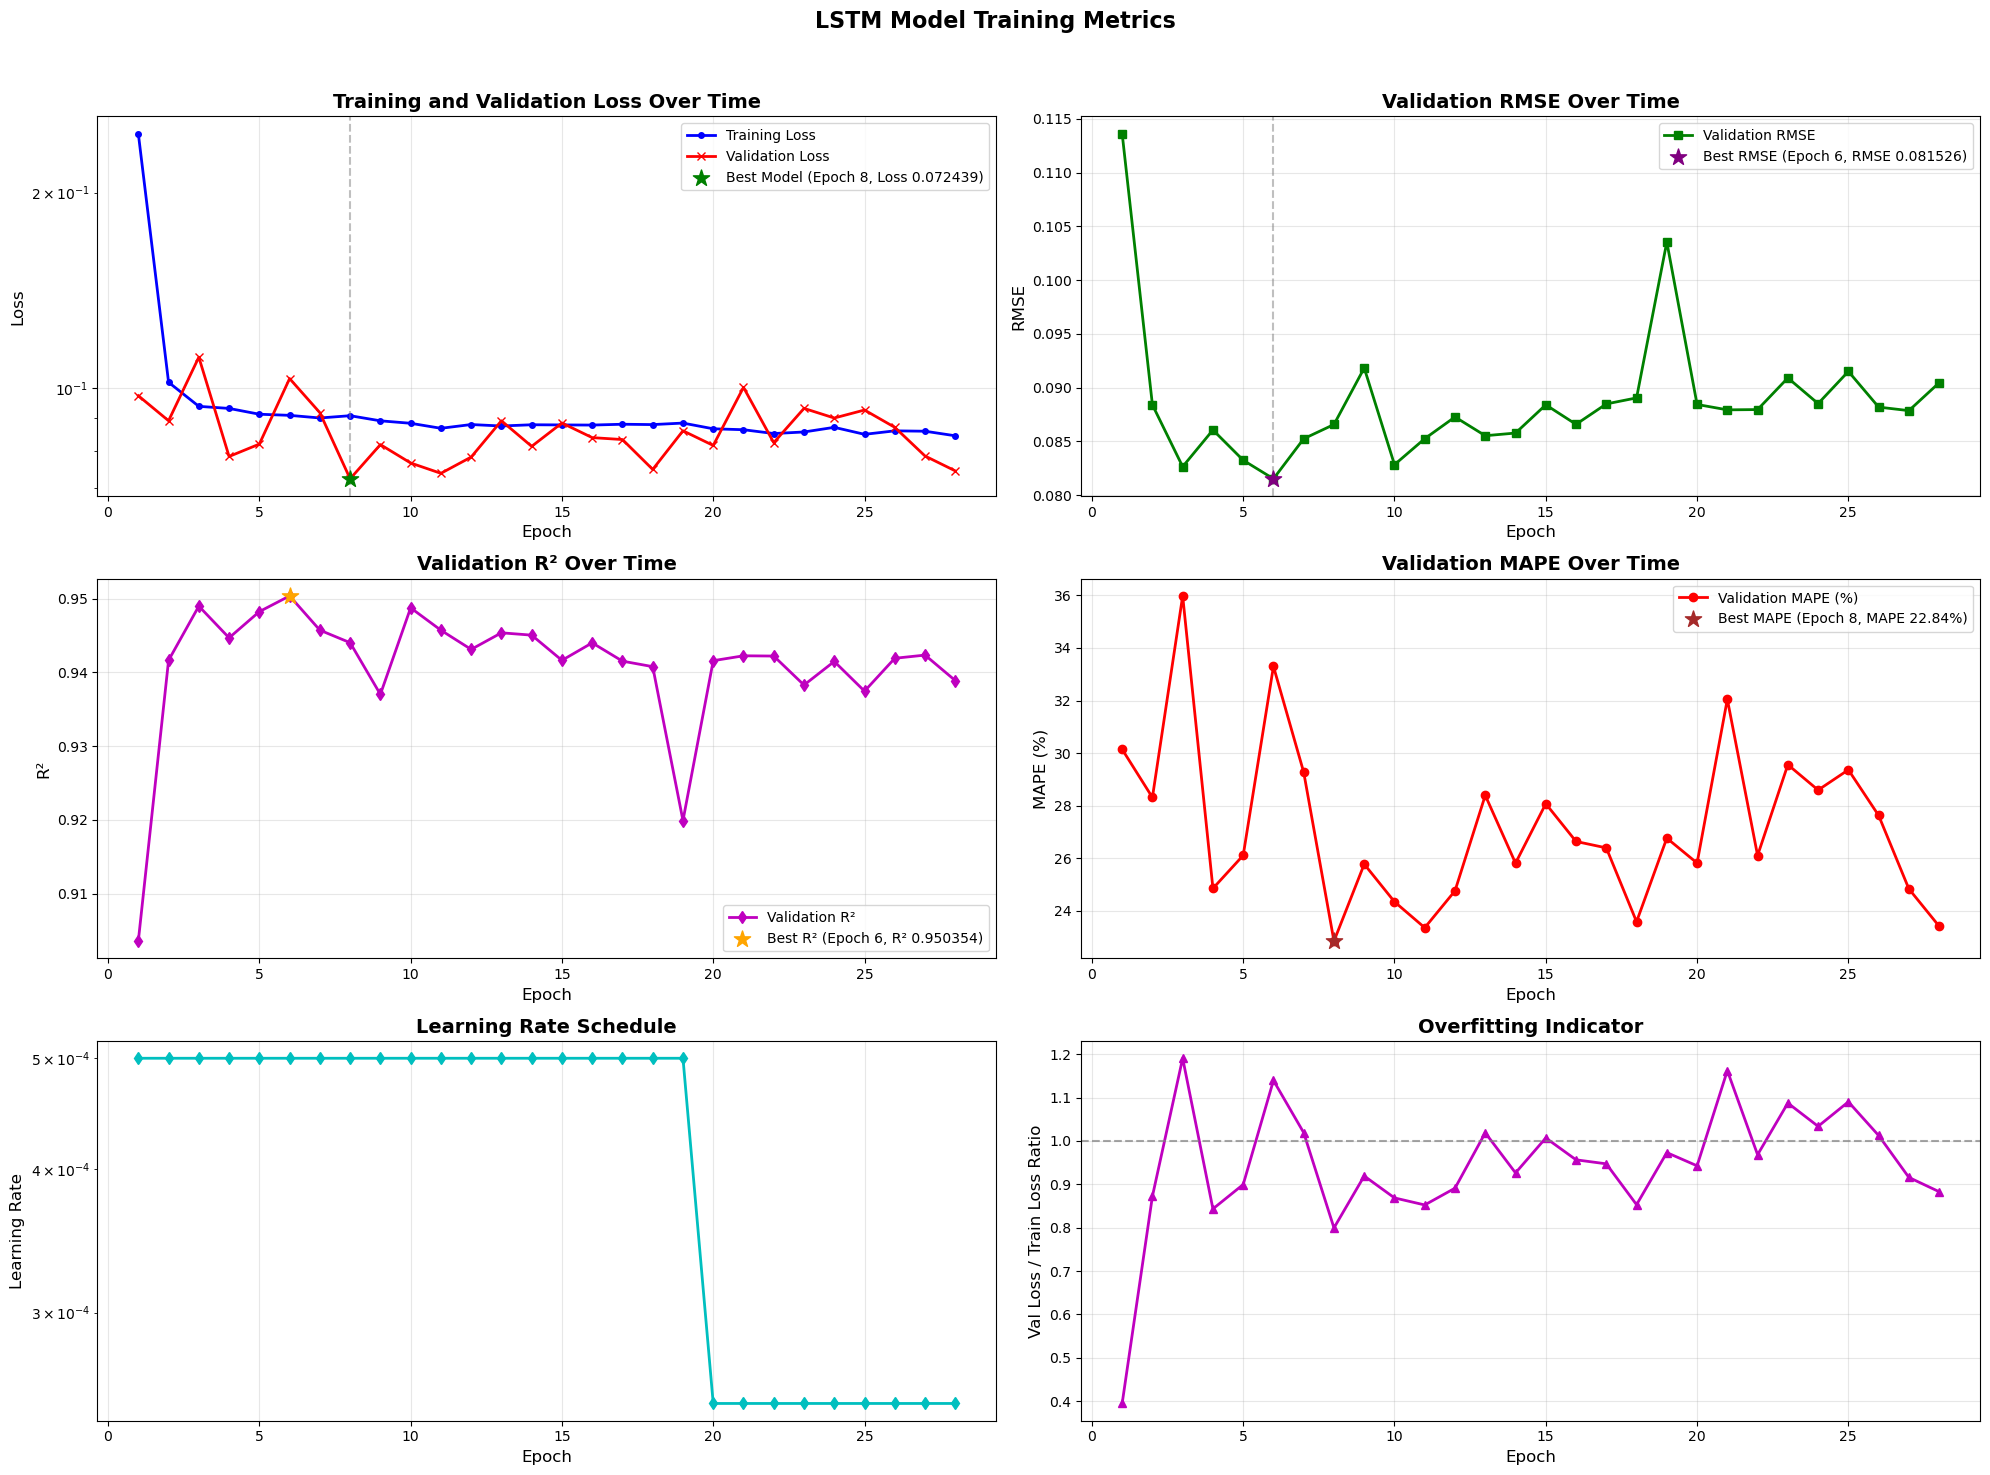

In [15]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = combined_transform_info  # Store the whole transform_info object

In [20]:
# Evaluate on test data
predictions, actuals, metrics = model.evaluate(
    X_test, y_test,
    target_scaler=scalers["Radiation_log1p"], # Use the log1p key
    transform_info=combined_transform_info,
)
    
# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


Scaled Metrics:
Test RMSE: 0.154937
Test R²: 0.816918
Test MAPE (capped at 100%): 36.57%

Original Scale Metrics:
Test RMSE: 266.049164
Test R²: -0.003787
Test MAPE (capped at 100%): 43.29%


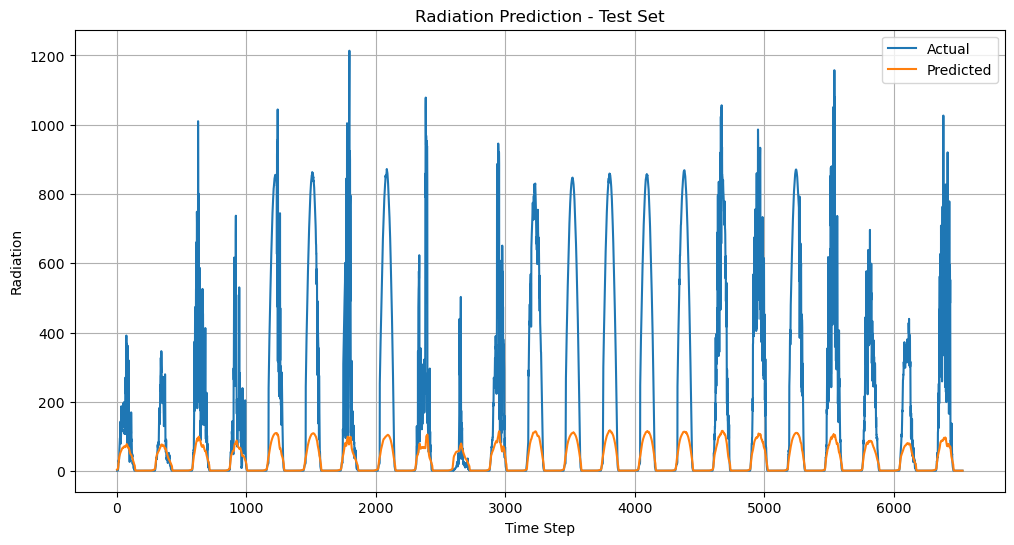

In [21]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

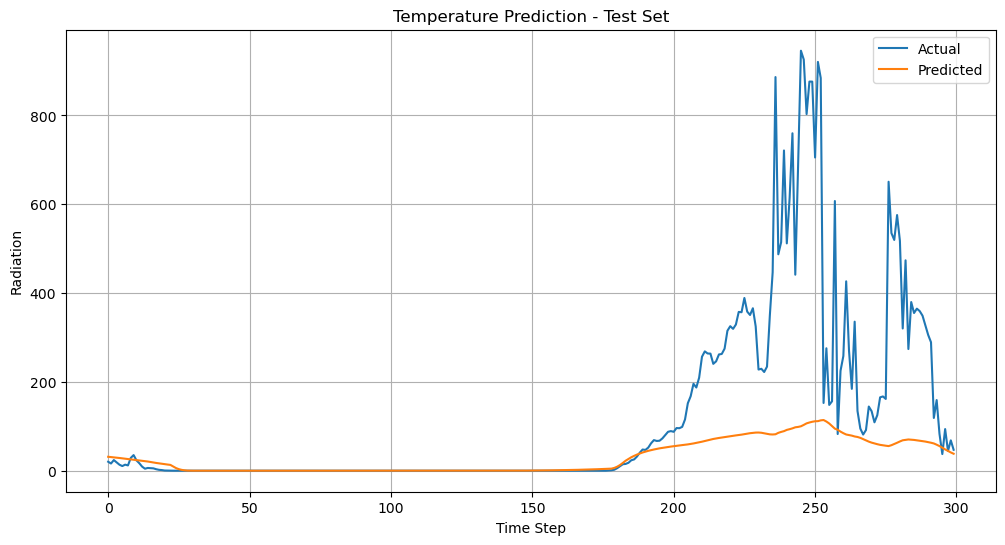

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[2700:3000], label='Actual')
plt.plot(predictions[2700:3000], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plot_utils as pu 

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [ ]:
model.save('weather_lstm_model.pt')

# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.